In [1]:
import os
from os.path import exists

import anchor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *
import re

In [2]:
data_path = "simulationVictorTopological/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-psr.csv"
feature_labels = ['x','y']
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"PS_SVM_safe.sav")

test = pd.read_csv(data_path+"test_ps.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)



In [3]:
test.describe()

,x,y,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.992839,5.128687,-0.064000,0.060000
std,2.892676,4.064634,0.998449,0.998698
min,0.026555,-4.190374,-1.000000,-1.000000
25%,2.477133,2.301952,-1.000000,-1.000000
50%,4.842608,5.107767,-1.000000,1.000000
75%,7.582407,8.009389,1.000000,1.000000
max,9.998768,14.830205,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,y > 2.17,0.7495,0.565034,-1.0,-1.0,-1.0
1,1,y <= 2.17,0.2533,0.991870,1.0,1.0,1.0
2,2,x <= 5.12 AND y <= 8.02,0.4783,0.522983,-1.0,-1.0,-1.0
3,3,y <= 2.17,0.2488,0.965174,1.0,1.0,1.0
4,4,y > 2.17,0.7530,0.610778,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...
957,995,y > 2.17,0.7433,0.587354,-1.0,-1.0,-1.0
958,996,y <= 2.17,0.2494,0.956332,1.0,1.0,1.0
959,997,y <= 2.17,0.2501,0.969697,1.0,1.0,1.0
960,998,y > 2.17,0.7514,0.539550,-1.0,-1.0,-1.0


In [5]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
y <= 2.17    221
y <= 5.00    131
x > 7.65     101
y <= 8.02     25
x > 5.12      13
x > 2.47       1
Name: count, dtype: int64

In [6]:
model.get_params()

{'alpha': array([ 1.53751795e-05,  5.00012163e-01,  4.70027443e-06, ...,
         2.44375993e-02, -1.61108163e-06,  8.18330832e-03]),
 'b': array([-0.00040652]),
 'b_eps': -0.9622658233374131,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

# Candidate selection

Text(0, 0.5, 'Count')

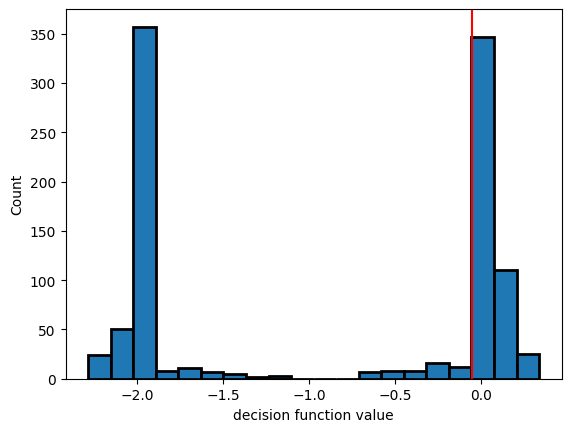

In [7]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [8]:
model.b_eps

-0.9622658233374131

In [11]:
d_thresh = 0.10

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 15


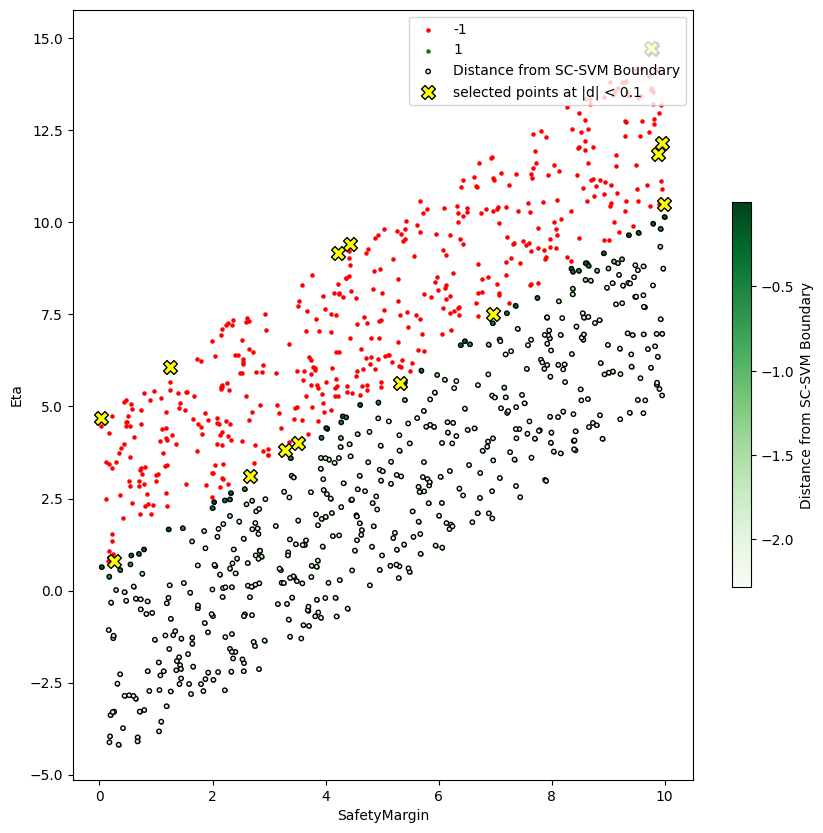

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Gráficos 2D sin la tercera variable (Z)
sc0 = ax.scatter(X_test[:, 0][y_cp_test == -1], X_test[:, 1][y_cp_test == -1], s=5, c="red", label="-1")
scsafe = ax.scatter(X_test[:, 0][y_cp_test == 1], X_test[:, 1][y_cp_test == 1], s=5, c="green", label="1")

sc1 = ax.scatter(X_test[:, 0][y_cp_test == 1], X_test[:, 1][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1],
                 cmap="Greens", edgecolors="k", label="Distance from SC-SVM Boundary")

sc2 = ax.scatter(X_test[list(border_points_idx), 0], X_test[list(border_points_idx), 1], s=100, marker='X',
                 facecolors="yellow", edgecolors="k", label=f"selected points at |d| < {d_thresh}")

# Etiquetas de los ejes
ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")

# Leyenda y barra de color
ax.legend(loc="upper right")
plt.colorbar(sc1, label="Distance from SC-SVM Boundary", shrink=0.5)

plt.show()

# Select the anchors for the candidate points

In [13]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [14]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [15]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
# '''
# # define a threshold for filtering on covering
# covering_threshold = 0.1

# rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

# rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

# rules_selected
# '''

In [16]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
x > 7.65     5
y <= 5.00    2
y <= 8.02    2
y <= 2.17    1
x > 2.47     1
x > 5.12     1
Name: count, dtype: int64

# Performance Evaluation


In [17]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        error = fptot/(fptot+tntot)
        print(f"precision: {prec}, covering: {cov}, error: {error}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass



In [18]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
70,70,y <= 5.00,0.4970,0.838527,1.0,1.0,-1.0
90,90,y <= 2.17,0.2507,1.000000,1.0,1.0,-1.0
109,109,y <= 8.02,0.7557,0.736301,1.0,1.0,-1.0
171,177,x > 7.65,0.2427,0.798732,1.0,1.0,-1.0
553,577,x > 2.47,0.7512,0.632066,1.0,1.0,-1.0
709,739,x > 5.12,0.4930,0.742053,1.0,1.0,-1.0


# Evaluation on true labels

In [19]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: y <= 5.00
tp = 354, tn = 392, fp = 140, fn = 114
precision: 0.7165991902834008, covering: 0.7564102564102564, error: 0.2631578947368421, accuracy: 0.746, f1: 0.735966735966736

rule: y <= 2.17
tp = 226, tn = 513, fp = 19, fn = 242
precision: 0.9224489795918367, covering: 0.4829059829059829, error: 0.03571428571428571, accuracy: 0.739, f1: 0.6339410939691444

rule: y <= 8.02
tp = 444, tn = 226, fp = 306, fn = 24
precision: 0.592, covering: 0.9487179487179487, error: 0.575187969924812, accuracy: 0.67, f1: 0.729064039408867

rule: x > 7.65
tp = 116, tn = 409, fp = 123, fn = 352
precision: 0.48535564853556484, covering: 0.24786324786324787, error: 0.231203007518797, accuracy: 0.525, f1: 0.32814710042432815

rule: x > 2.47
tp = 360, tn = 141, fp = 391, fn = 108
precision: 0.4793608521970706, covering: 0.7692307692307693, error: 0.7349624060150376, accuracy: 0.501, f1: 0.5906480721903199

rule: x > 5.12
tp = 226, tn = 286, fp = 246, fn = 242
precision: 0.4788135593220339, covering: 0.4

# evaluation on safety checker labels

In [20]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: y <= 5.00
tp = 381, tn = 357, fp = 113, fn = 149
precision: 0.771255060728745, covering: 0.7188679245283018, error: 0.2404255319148936, accuracy: 0.738, f1: 0.744140625

rule: y <= 2.17
tp = 236, tn = 461, fp = 9, fn = 294
precision: 0.963265306122449, covering: 0.44528301886792454, error: 0.019148936170212766, accuracy: 0.697, f1: 0.6090322580645161

rule: y <= 8.02
tp = 487, tn = 207, fp = 263, fn = 43
precision: 0.6493333333333333, covering: 0.9188679245283019, error: 0.5595744680851064, accuracy: 0.694, f1: 0.7609375

rule: x > 7.65
tp = 134, tn = 365, fp = 105, fn = 396
precision: 0.5606694560669456, covering: 0.2528301886792453, error: 0.22340425531914893, accuracy: 0.499, f1: 0.34850455136540964

rule: x > 2.47
tp = 405, tn = 124, fp = 346, fn = 125
precision: 0.5392809587217043, covering: 0.7641509433962265, error: 0.7361702127659574, accuracy: 0.529, f1: 0.6323185011709602

rule: x > 5.12
tp = 256, tn = 254, fp = 216, fn = 274
precision: 0.5423728813559322, covering: 0.4

**Evaluate the $\lor$ of the rules**

In [21]:
verified1 = (X_test[:,0] <= 2.75) 

verified2 = (X_test[:,1] <= 2.75) 

verified_or = verified1|verified2
prec, cov, acc, fscore, err = ComputeMetricsForRule(verified_or, y_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")                                                             

tp = 398, tn = 454, fp = 108, fn = 40
precision: 0.7865612648221344, covering: 0.908675799086758, accuracy: 0.852, f1: 0.8432203389830508, error: 0.2134387351778656


In [22]:
prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")   

tp = 392, tn = 494, fp = 114, fn = 0
precision: 0.7747035573122529, covering: 1.0, accuracy: 0.886, f1: 0.8730512249443207, error: 0.22529644268774704
